In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans,DBSCAN, AgglomerativeClustering
from scipy import stats
from statistics import mean
import os
from sklearn.metrics.pairwise import euclidean_distances
import math

# Get data from 10x

In [39]:
!wget https://cf.10xgenomics.com/samples/cell-vdj/3.0.2/vdj_v1_hs_aggregated_donor1/vdj_v1_hs_aggregated_donor1_filtered_feature_bc_matrix.tar.gz -P data/
    

--2023-01-18 19:54:37--  https://cf.10xgenomics.com/samples/cell-vdj/3.0.2/vdj_v1_hs_aggregated_donor1/vdj_v1_hs_aggregated_donor1_filtered_feature_bc_matrix.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 188.114.98.236, 188.114.99.236, 2a06:98c1:3122:e000::c, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|188.114.98.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 296410621 (283M) [application/x-tar]
Saving to: ‘data/vdj_v1_hs_aggregated_donor1_filtered_feature_bc_matrix.tar.gz’

vdj_v1_hs_aggregate 100%[===================>] 282.68M  3.50MB/s    in 2m 51s  

2023-01-18 19:57:28 (1.66 MB/s) - ‘data/vdj_v1_hs_aggregated_donor1_filtered_feature_bc_matrix.tar.gz’ saved [296410621/296410621]



In [83]:
!wget https://cf.10xgenomics.com/samples/cell-vdj/3.0.2/vdj_v1_hs_aggregated_donor1/vdj_v1_hs_aggregated_donor1_all_contig_annotations.csv -P data/

--2023-01-19 07:51:15--  https://cf.10xgenomics.com/samples/cell-vdj/3.0.2/vdj_v1_hs_aggregated_donor1/vdj_v1_hs_aggregated_donor1_all_contig_annotations.csv
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 188.114.98.236, 188.114.99.236, 2a06:98c1:3122:e000::c, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|188.114.98.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33851101 (32M) [text/csv]
Saving to: ‘data/vdj_v1_hs_aggregated_donor1_all_contig_annotations.csv’

vdj_v1_hs_aggregate 100%[===================>]  32.28M  6.81MB/s    in 4.7s    

2023-01-19 07:51:22 (6.81 MB/s) - ‘data/vdj_v1_hs_aggregated_donor1_all_contig_annotations.csv’ saved [33851101/33851101]



In [41]:
!gunzip data/vdj_v1_hs_aggregated_donor1_filtered_feature_bc_matrix.tar.gz

In [43]:
!tar -xvf data/vdj_v1_hs_aggregated_donor1_filtered_feature_bc_matrix.tar -C data/

filtered_feature_bc_matrix/
filtered_feature_bc_matrix/matrix.mtx.gz
filtered_feature_bc_matrix/features.tsv.gz
filtered_feature_bc_matrix/barcodes.tsv.gz


In [45]:
!gunzip data/filtered_feature_bc_matrix/matrix.mtx.gz
!gunzip data/filtered_feature_bc_matrix/features.tsv.gz
!gunzip data/filtered_feature_bc_matrix/barcodes.tsv.gz

# Code

In [3]:
def read_barcodes(barcodes_file):
    barcodes = pd.read_csv(barcodes_file, sep = '\t',header = None)
    barcodes.columns = ['barcode']
    barcodes.index += 1
    barcodes['barcode_id'] = barcodes.index
    return barcodes

def read_features(features_file):
    features = pd.read_csv(features_file, sep = '\t',header = None)
    features.index += 1
    features.columns = ['feature_code','value','type']
    features['feature_id'] = features.index
    features['feature_id'] = pd.to_numeric(features['feature_id'])
    return features

def read_matrix(matrix_file):
    matrix = pd.read_csv(matrix_file,sep = '\t')
    matrix = matrix.drop([0])
    matrix[['feature_id','barcode_id', 'count']] = matrix['%%MatrixMarket matrix coordinate integer general'].str.split(expand=True)
    matrix = matrix.drop(['%%MatrixMarket matrix coordinate integer general'], axis = 1)
    matrix = matrix.apply(pd.to_numeric)
    matrix['count']=matrix['count'].astype(int)
    return matrix

def merge_matrix(matrix,barcodes,features):
    matrix = pd.merge(matrix, barcodes, on="barcode_id")
    matrix = pd.merge(matrix, features, on="feature_id")
    #matrix = matrix.drop(['barcode_id','feature_id'],axis=1)
    return matrix


def get_value_matrix(matrix):
    v_t = matrix['value'].str.split('_',n=1,expand=True)
    matrix['value']=v_t[0]
    matrix['value_type']=v_t[1]
    return matrix

def get_tetramer_matrix(matrix):
    matrix = matrix.sort_values(by=['count'],ascending=False)
    tetramers = matrix.drop_duplicates('barcode')
    tetramers = tetramers[tetramers['count']>5]
    tetramers['tetramer'] = tetramers['value']
    tetramers =  tetramers[['barcode_id','tetramer']]
    matrix = pd.merge(matrix, tetramers, on="barcode_id")
    return matrix[['barcode','value','tetramer','count']]

In [4]:
def prep_annot_data(data):
    data_c = data[data['is_cell']==True].reset_index(drop=True)
    data_c = data_c[data_c['chain'] == "TRB"]
    
    data_c = data_c[-data_c['v_gene'].isna()]
    data_c = data_c[-data_c['j_gene'].isna()]
    
    data_c = data_c[-data_c['cdr3'].isna()]
    #data_no_10x = data_no_10x[-data_no_10x['antigen.epitope'].isna()]
    data_c = data_c[-data_c['v_gene'].str.contains(',')]
    data_c = data_c[-data_c['j_gene'].str.contains(',')]
    data_c = data_c[-data_c['cdr3'].str.contains('\*')]
    return data_c

def merge_anot_matrix(data_c,matrix):
    data_c = pd.merge(data_c,matrix, on='barcode')
    data_c = data_c[['cdr3','count','tetramer','value','barcode']]
    data_c = data_c[data_c['cdr3']!='None']
    return data_c

### Normalization code

In [5]:
def sum_counts(data, cell_col_name, count_col_name, cell):
    return sum(data[data[cell_col_name]==cell][count_col_name])

def norm_logp_with_total_average(data, cell_id_col, count_col):
    # total count for cell
    cell_all_counts = pd.DataFrame(data[cell_id_col].drop_duplicates())
    cell_all_counts['counts']= cell_all_counts[cell_id_col].apply(lambda x: sum_counts(data_c_all,cell_id_col,count_col,x))
    
    cell_all_counts_dict = pd.Series(cell_all_counts['counts'].values,index=cell_all_counts[cell_id_col]).to_dict()
    ## average total count for cell
    average_total_count = cell_all_counts['counts'].mean()
    ## normalize log(1 + count / (total count for cell) * (average total count for cell)) 
    data['count']= data.apply(lambda row : math.log(1 + row[count_col]/cell_all_counts_dict[row[cell_id_col]]*average_total_count),axis=1)
    return data
    
    
def norm_logp(data, count_col):
    data[count_col]= data[count_col].apply(lambda x : math.log1p(x))
    return data
    

### Pivot code

In [6]:
def pivot_data_old(data):
    data = data[['count','cdr3','value']]
    data = data.pivot_table('count','cdr3','value')
    data = data.fillna(0)
    return data

In [7]:
def pivot_data(data):
    data = data[['count','barcode','value']]
    data = data.pivot_table('count','barcode','value')
    data = data.fillna(0)
    return data

### PCA code

In [8]:
def pca(data, n):
    
    if type(n) == int:
        x = StandardScaler().fit_transform(data)
        pca = PCA(n_components = n )
        principalComponents = pca.fit_transform(x)
        df_pca = pd.DataFrame(data = principalComponents)
        return df_pca, pca
        
    else:
        return data, pca

### TSNE code

In [9]:
def tsne(data,n,random_s,p):
    if type(n) == int:
        X_embedded = TSNE(n_components=n,init='pca',
                         random_state=random_s, perplexity=p).fit_transform(data)
        return X_embedded

## Reading and processing raw data

In [10]:
barcodes = read_barcodes('data/filtered_feature_bc_matrix/barcodes.tsv')
features = read_features('data/filtered_feature_bc_matrix/features.tsv')
matrix = read_matrix('data/filtered_feature_bc_matrix/matrix.mtx')
matrix = merge_matrix(matrix,barcodes,features)
matrix = get_value_matrix(matrix)

matrix = matrix[matrix['type']=='Antibody Capture']
matrix = matrix[matrix['value_type']!='TotalSeqC']
matrix_t = get_tetramer_matrix(matrix)

In [11]:
matrix_t.size

819904

In [12]:
matrix_t.head(5)

barcode      value   tetramer     count
0  TTTGTCATCAGGTAAA-40  AAKGRGAAL  AAKGRGAAL  76112470
1  TTTGTCATCAGGTAAA-40  QYDPVAALF  AAKGRGAAL         2
2  TTTGTCATCAGGTAAA-40  KLGGALQAK  AAKGRGAAL         1
3  TTTGTCATCAGGTAAA-40  NLVPMVATV  AAKGRGAAL         1
4  TTTGTCATCAGGTAAA-40  QPRAPIRPI  AAKGRGAAL         1

In [13]:
data = pd.read_csv("data/vdj_v1_hs_aggregated_donor1_all_contig_annotations.csv", sep = ',')
data_c_annot = prep_annot_data(data)
data_c = data_c_annot.copy()
data_c = merge_anot_matrix(data_c,matrix_t)
data_c['count'].mean()

375.7858468262266

In [14]:
data_c['count'].median()

2.0

In [15]:
data_c_all = data_c.copy()

In [16]:
v_param = '190123'
data_c_all_path = 'data_scripts/10x_tetramer_annot' + v_param + '.txt'
matrix_path = 'data_scripts/10x_tetramer_matrix' + v_param + '.txt'
data_c_all.to_csv(data_c_all_path, sep='\t', index = False)
matrix_t.to_csv(matrix_path, sep='\t', index = False)

# Analysis

In [17]:
data_c_all = pd.read_csv(data_c_all_path, sep='\t')
data_c_all.head(5)

cdr3  count    tetramer       value              barcode
0  CATSRDRGHGDTIYF      6   KLGGALQAK   KLGGALQAK  AAACCTGAGAGTGAGA-23
1  CATSRDRGHGDTIYF      1   KLGGALQAK  AVFDRKSDAK  AAACCTGAGAGTGAGA-23
2  CATSRDRGHGDTIYF      1   KLGGALQAK   RLRAEAQVK  AAACCTGAGAGTGAGA-23
3   CASSLYSATGELFF    451  AVFDRKSDAK  AVFDRKSDAK  AAACCTGAGATTACCC-16
4   CASSLYSATGELFF      4  AVFDRKSDAK   KLGGALQAK  AAACCTGAGATTACCC-16

In [18]:
matrix_t = pd.read_csv(matrix_path, sep='\t')
matrix_t.head(5)

barcode      value   tetramer     count
0  TTTGTCATCAGGTAAA-40  AAKGRGAAL  AAKGRGAAL  76112470
1  TTTGTCATCAGGTAAA-40  QYDPVAALF  AAKGRGAAL         2
2  TTTGTCATCAGGTAAA-40  KLGGALQAK  AAKGRGAAL         1
3  TTTGTCATCAGGTAAA-40  NLVPMVATV  AAKGRGAAL         1
4  TTTGTCATCAGGTAAA-40  QPRAPIRPI  AAKGRGAAL         1

### logP normalization

Нормировка logp
Без отсечки по кайнтам

In [19]:
data_c_n = norm_logp(data_c_all, 'count')
barcode_tetramer = data_c_n[['barcode','tetramer']].drop_duplicates()
data_c_p = pivot_data(data_c_n)

In [20]:
data_c_p

value                AAKGRGAAL  ALIAPVHAV  AVFDRKSDAK  AYAQKIFKI  AYSSAGASI  \
barcode                                                                       
AAACCTGAGAGTGAGA-23   0.000000   0.000000    0.693147        0.0   0.000000   
AAACCTGAGATTACCC-16   0.000000   0.693147    6.113682        0.0   0.693147   
AAACCTGAGGCTCATT-34   0.000000   0.693147    1.098612        0.0   0.000000   
AAACCTGAGGGAGTAA-40   0.693147   1.098612    5.192957        0.0   0.000000   
AAACCTGAGGTGCACA-13   0.000000   0.000000    4.430817        0.0   0.000000   
...                        ...        ...         ...        ...        ...   
TTTGTCATCCGAAGAG-35   0.000000   0.000000    2.944439        0.0   0.000000   
TTTGTCATCCTATGTT-26   0.000000   0.000000    2.079442        0.0   0.000000   
TTTGTCATCGAGGTAG-13   0.000000   0.000000    1.791759        0.0   0.000000   
TTTGTCATCTCCTATA-36   0.000000   0.000000    2.708050        0.0   0.000000   
TTTGTCATCTGTCAAG-32   0.000000   0.000000    2.833213        0.0   0.000000   

value                CLGGLLTMV  CLLGTYTQDV  CLLWSFQTSA  CYTWNQMNL  ELAGIGILTV  \
barcode                                                                         
AAACCTGAGAGTGAGA-23        0.0         0.0         0.0        0.0    0.000000   
AAACCTGAGATTACCC-16        0.0         0.0         0.0        0.0    0.693147   
AAACCTGAGGCTCATT-34        0.0         0.0         0.0        0.0    0.000000   
AAACCTGAGGGAGTAA-40        0.0         0.0         0.0        0.0    0.000000   
AAACCTGAGGTGCACA-13        0.0         0.0         0.0        0.0    0.000000   
...                        ...         ...         ...        ...         ...   
TTTGTCATCCGAAGAG-35        0.0         0.0         0.0        0.0    0.000000   
TTTGTCATCCTATGTT-26        0.0         0.0         0.0        0.0    0.000000   
TTTGTCATCGAGGTAG-13        0.0         0.0         0.0        0.0    0.000000   
TTTGTCATCTCCTATA-36        0.0         0.0         0.0        0.0    0.000000   
TTTGTCATCTGTCAAG-32        0.0         0.0         0.0        0.0    0.000000   

value                ...  SLEGGGLGY  SLFNTVATL  SLFNTVATLY  SLLMWITQV  \
barcode              ...                                                
AAACCTGAGAGTGAGA-23  ...        0.0   0.000000         0.0   0.000000   
AAACCTGAGATTACCC-16  ...        0.0   0.693147         0.0   0.000000   
AAACCTGAGGCTCATT-34  ...        0.0   0.000000         0.0   0.000000   
AAACCTGAGGGAGTAA-40  ...        0.0   0.000000         0.0   0.693147   
AAACCTGAGGTGCACA-13  ...        0.0   0.000000         0.0   0.000000   
...                  ...        ...        ...         ...        ...   
TTTGTCATCCGAAGAG-35  ...        0.0   0.000000         0.0   0.000000   
TTTGTCATCCTATGTT-26  ...        0.0   0.000000         0.0   0.000000   
TTTGTCATCGAGGTAG-13  ...        0.0   0.000000         0.0   0.000000   
TTTGTCATCTCCTATA-36  ...        0.0   0.000000         0.0   0.000000   
TTTGTCATCTGTCAAG-32  ...        0.0   0.000000         0.0   0.000000   

value                SLYNTVATLY  STEGGGLAY  TPRVTGGGAM  VTEHDTLLY  YLLEMLWRL  \
barcode                                                                        
AAACCTGAGAGTGAGA-23    0.000000   0.000000    0.000000   0.000000        0.0   
AAACCTGAGATTACCC-16    0.693147   0.693147    0.000000   0.000000        0.0   
AAACCTGAGGCTCATT-34    0.000000   0.000000    0.000000   0.693147        0.0   
AAACCTGAGGGAGTAA-40    0.000000   0.693147    0.693147   0.000000        0.0   
AAACCTGAGGTGCACA-13    0.000000   0.000000    0.000000   0.000000        0.0   
...                         ...        ...         ...        ...        ...   
TTTGTCATCCGAAGAG-35    0.000000   0.000000    0.000000   0.000000        0.0   
TTTGTCATCCTATGTT-26    0.000000   0.000000    0.000000   0.000000        0.0   
TTTGTCATCGAGGTAG-13    0.000000   0.000000    0.000000   0.000000        0.0   
TTTGTCATCTCCTATA-36    0.000000   0.000000    0.000000   0.000000        0.0   
TTTGTCAT

In [20]:
pca_df, pca_model = pca(data_c_p,50)
pca_df_data = pca_df.copy()
pca_df_data['barcode']=data_c_p.index

pca_df_data=pca_df_data.merge(barcode_tetramer, how='right', on='barcode')

<AxesSubplot:>

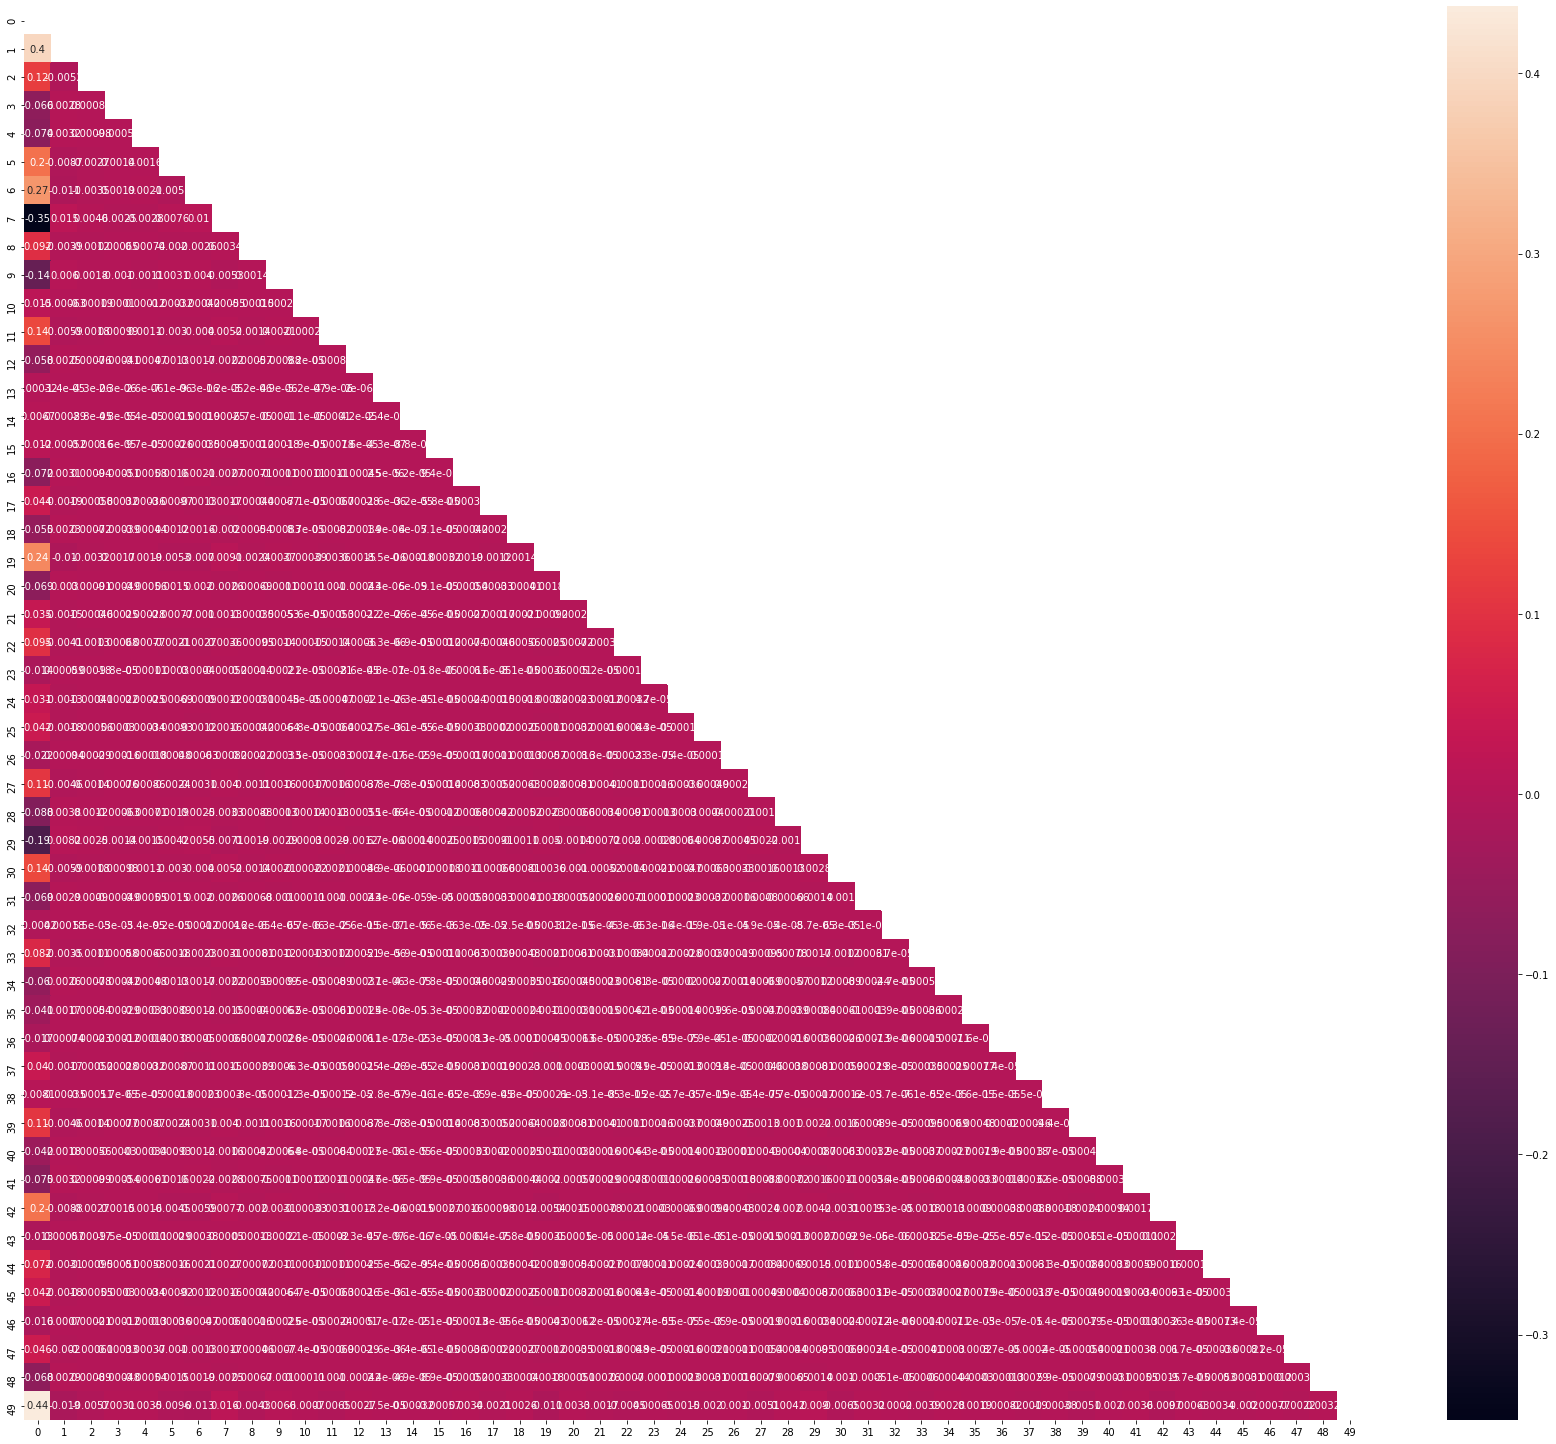

In [21]:
components_scores = pd.DataFrame(pca_model.components_.T)
corr_scores = components_scores.corr()

matrix = np.triu(corr_scores)
plt.figure(figsize=(30,26))
# using the upper triangle matrix as mask 
sns.heatmap(corr_scores, annot=True, mask=matrix)

#### TSNE on pca

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


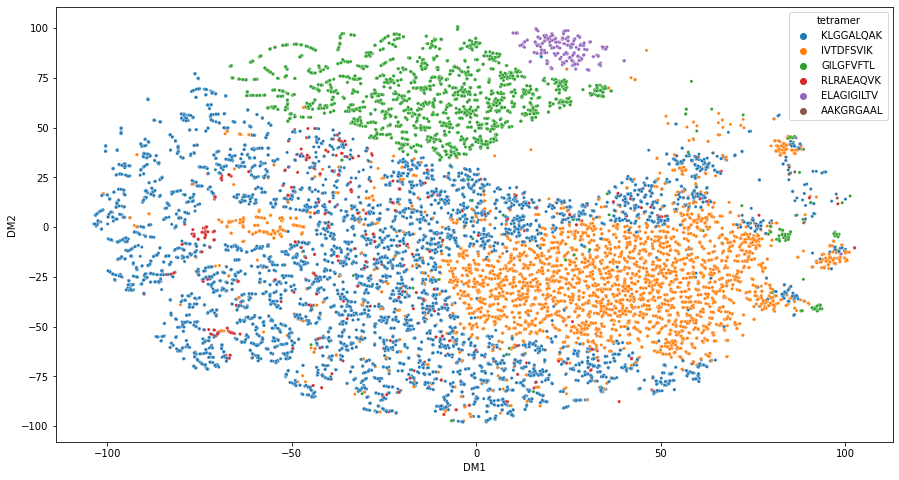

In [22]:
X_embedded_pca = tsne(pca_df,2,0,5)
tsne_pca_df = pd.DataFrame(data = X_embedded_pca, columns = ['DM1', 'DM2'])
#plt.figure(figsize=(15,8))
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
tsne_pca_df_data = tsne_pca_df.copy()
tsne_pca_df_data['barcode']=data_c_p.index
tsne_pca_df_data=tsne_pca_df_data.merge(barcode_tetramer, on='barcode')
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_pca_df_data[tsne_pca_df_data['tetramer'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=10)


#### TSNE on data

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


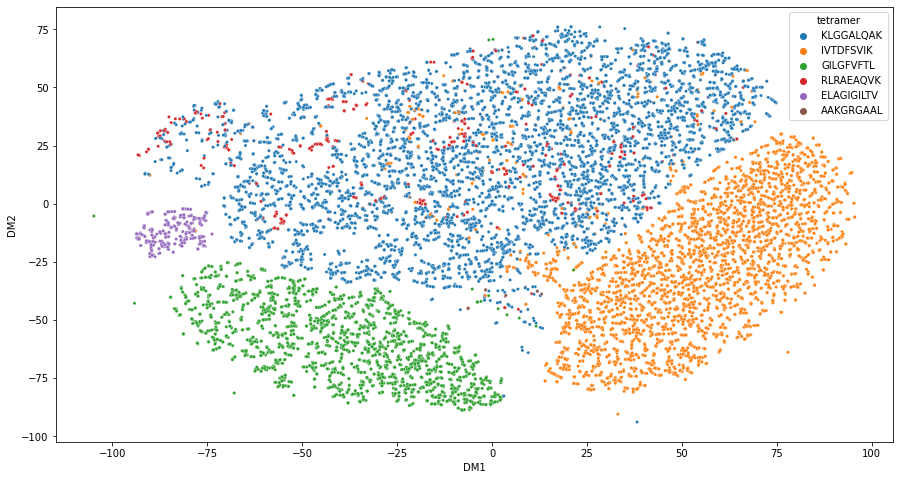

In [23]:
X_embedded = tsne(data_c_p,2,0,5)
tsne_df = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])
#plt.figure(figsize=(15,8))
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
tsne_df_data = tsne_df.copy()
tsne_df_data['barcode']=data_c_p.index
tsne_df_data=tsne_df_data.merge(barcode_tetramer, on='barcode')
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['tetramer'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=10)


### Another normalization with total and avegage

In [24]:
data_c_n = norm_logp_with_total_average(data_c_all, 'barcode','count')
barcode_tetramer = data_c_n[['barcode','tetramer']].drop_duplicates()
data_c_p = pivot_data(data_c_n)

In [25]:
pca_df, pca_model = pca(data_c_p,50)
pca_df_data = pca_df.copy()
pca_df_data['barcode']=data_c_p.index

<AxesSubplot:>

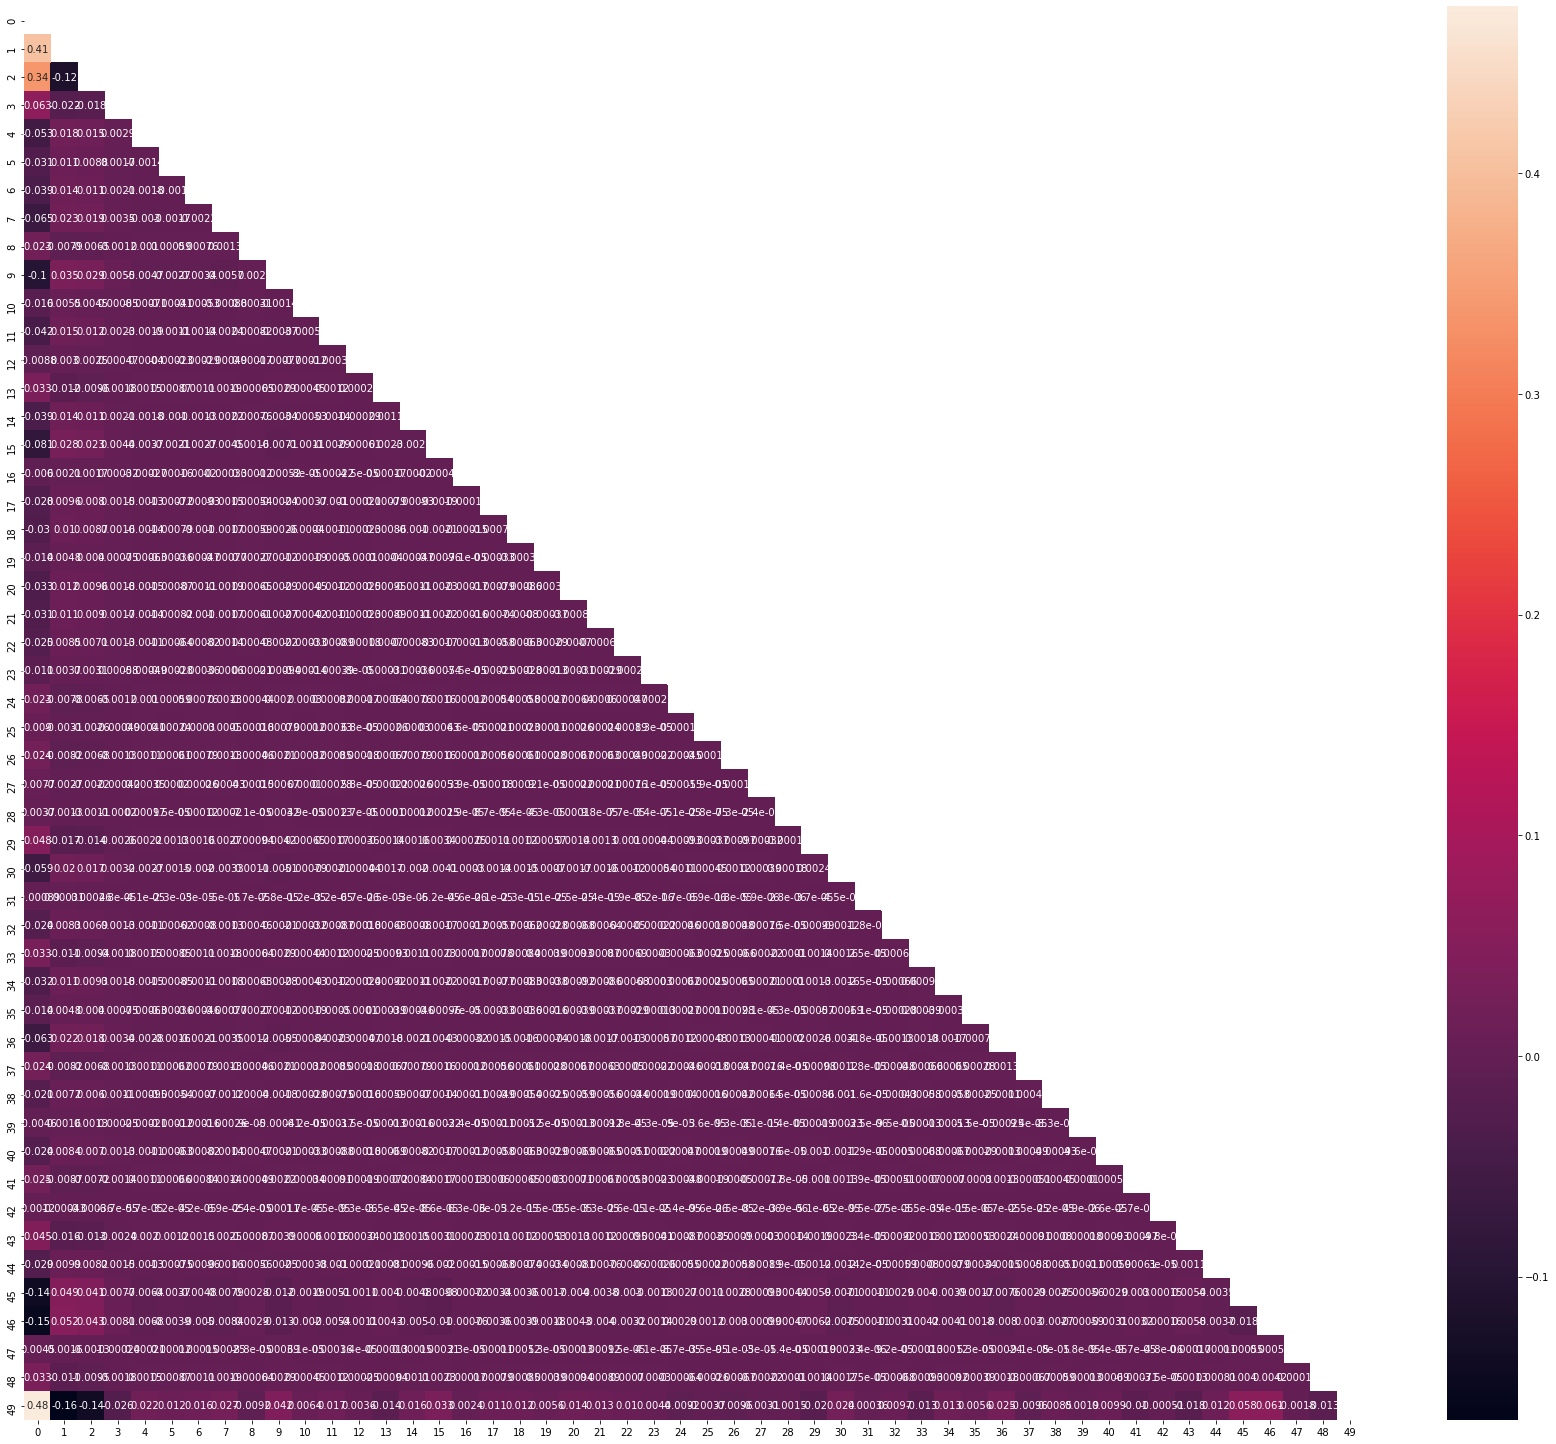

In [26]:
components_scores = pd.DataFrame(pca_model.components_.T)
corr_scores = components_scores.corr()

matrix = np.triu(corr_scores)
plt.figure(figsize=(30,26))
# using the upper triangle matrix as mask 
sns.heatmap(corr_scores, annot=True, mask=matrix)

#### TSNE on pca

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


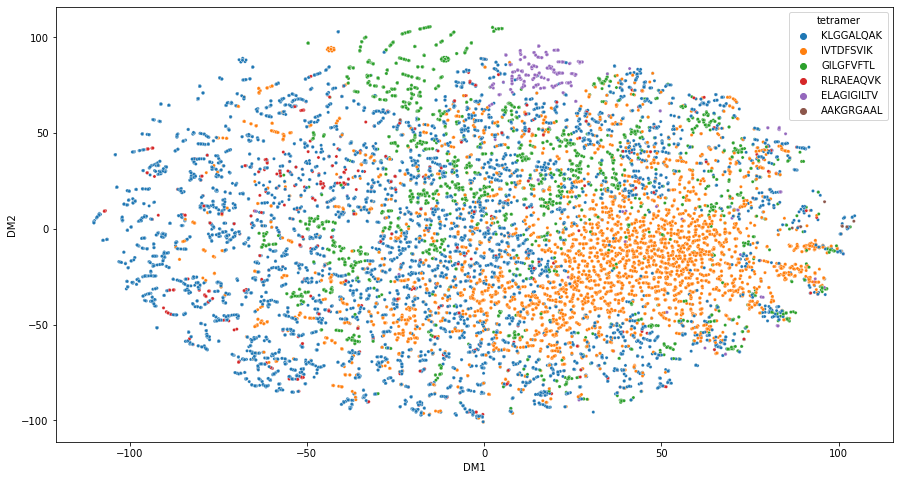

In [27]:
X_embedded_pca = tsne(pca_df,2,0,5)
tsne_pca_df = pd.DataFrame(data = X_embedded_pca, columns = ['DM1', 'DM2'])
#plt.figure(figsize=(15,8))
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
tsne_pca_df_data = tsne_pca_df.copy()
tsne_pca_df_data['barcode']=data_c_p.index
tsne_pca_df_data=tsne_pca_df_data.merge(barcode_tetramer, how='right', on='barcode')
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_pca_df_data[tsne_pca_df_data['tetramer'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=10)


#### TSNE on data

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


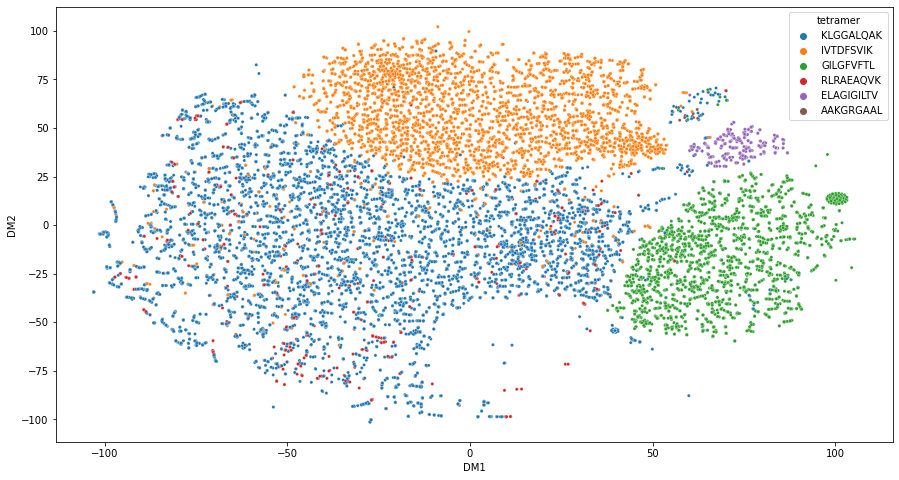

In [28]:
X_embedded = tsne(data_c_p,2,0,5)
tsne_df = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])
#plt.figure(figsize=(15,8))
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
tsne_df_data = tsne_df.copy()
tsne_df_data['barcode']=data_c_p.index
tsne_df_data=tsne_df_data.merge(barcode_tetramer, how='right', on='barcode')
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['tetramer'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=10)


### LogP without KLG

In [29]:
data_c_filter = data_c_all[data_c_all['tetramer']!='KLGGALQAK']

In [30]:
data_c_n = norm_logp(data_c_filter, 'count')
barcode_tetramer = data_c_n[['barcode','tetramer']].drop_duplicates()
data_c_p = pivot_data(data_c_n)

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [31]:
data_c_p_tetramer = data_c_p.copy()
data_c_p_tetramer = data_c_p_tetramer.merge(barcode_tetramer, on='barcode')

In [32]:
pca_df, pca_model = pca(data_c_p,49)
pca_df_data = pca_df.copy()
pca_df_data['barcode']=data_c_p.index

pca_df_data=pca_df_data.merge(barcode_tetramer, how='right', on='barcode' )

<AxesSubplot:>

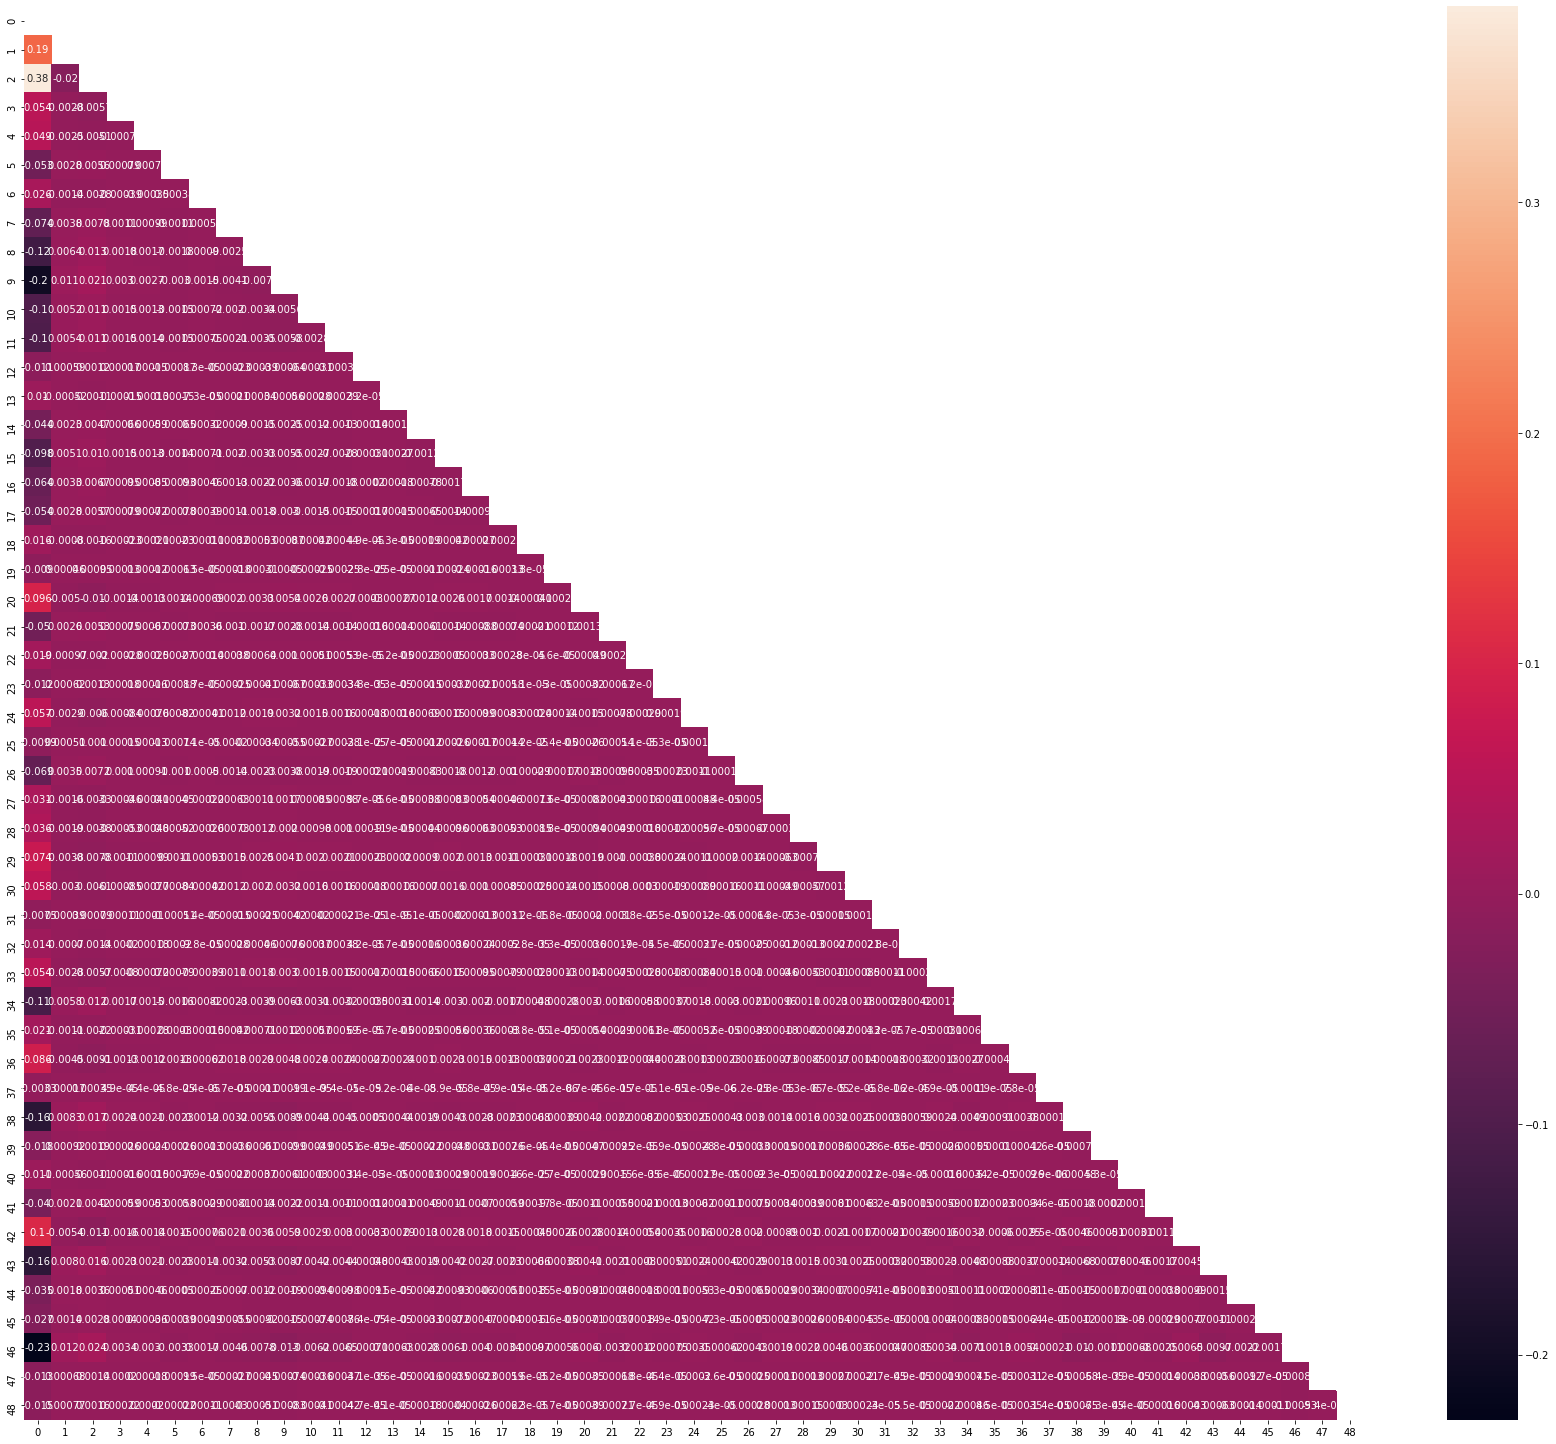

In [33]:
components_scores = pd.DataFrame(pca_model.components_.T)
corr_scores = components_scores.corr()

matrix = np.triu(corr_scores)
plt.figure(figsize=(30,26))
# using the upper triangle matrix as mask 
sns.heatmap(corr_scores, annot=True, mask=matrix)

#### TSNE on PCA

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


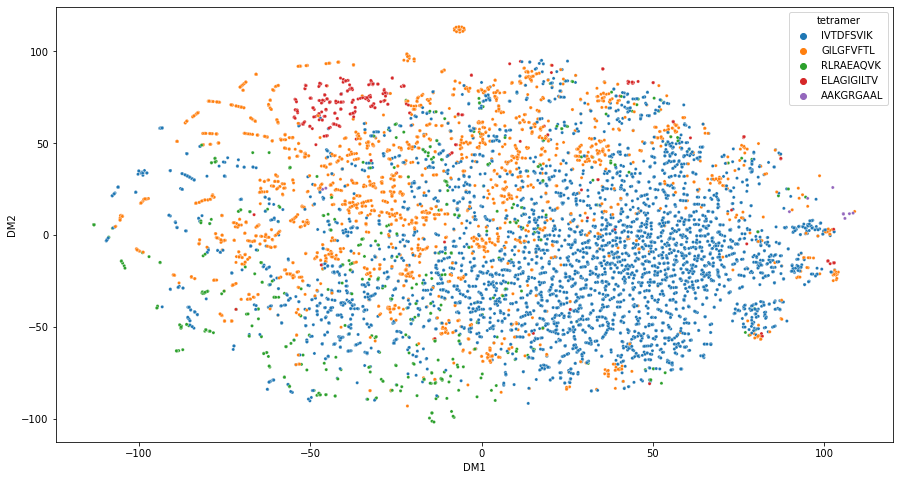

In [34]:
X_embedded_pca = tsne(pca_df,2,0,5)
tsne_pca_df = pd.DataFrame(data = X_embedded_pca, columns = ['DM1', 'DM2'])
#plt.figure(figsize=(15,8))
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
tsne_pca_df_data = tsne_pca_df.copy()
tsne_pca_df_data['barcode']=data_c_p.index
tsne_pca_df_data=tsne_pca_df_data.merge(barcode_tetramer, how='right', on='barcode')
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_pca_df_data[tsne_pca_df_data['tetramer'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=10)


#### TSNE on data

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


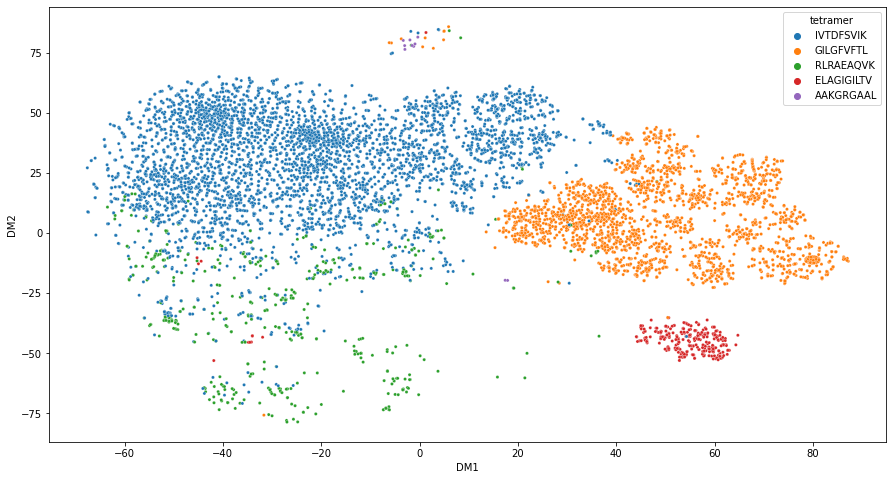

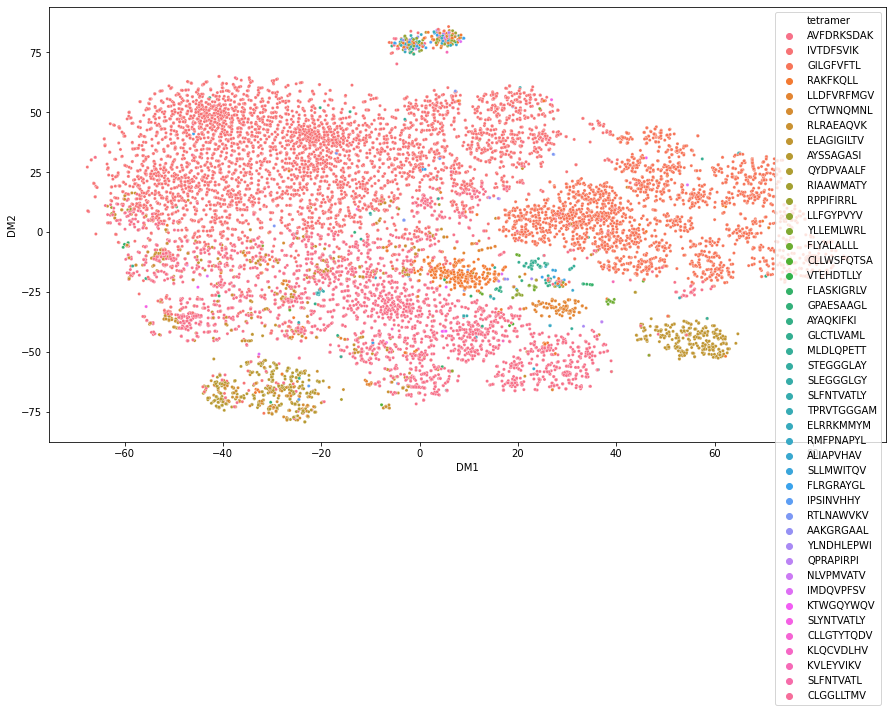

In [35]:
X_embedded = tsne(data_c_p,2,0,25)
tsne_df = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])
#plt.figure(figsize=(15,8))
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
tsne_df_data = tsne_df.copy()
tsne_df_data['barcode']=data_c_p.index
tsne_df_data=tsne_df_data.merge(barcode_tetramer, how='right', on='barcode')
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['tetramer'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=10)
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data, hue='tetramer',s=10)


### Clustering

In [36]:
#Clustering
#Kmeans
n_tetra = len(barcode_tetramer['tetramer'].drop_duplicates())
labels = data_c_p_tetramer['tetramer']
kmeans = KMeans(n_clusters=n_tetra, random_state=0).fit(data_c_p)

In [37]:
labels

0        AVFDRKSDAK
1         IVTDFSVIK
2        AVFDRKSDAK
3         GILGFVFTL
4         IVTDFSVIK
            ...    
12752    AVFDRKSDAK
12753    AVFDRKSDAK
12754     AAKGRGAAL
12755     GILGFVFTL
12756    AVFDRKSDAK
Name: tetramer, Length: 12757, dtype: object

In [38]:
clusters = pd.DataFrame(kmeans.labels_, columns= ['cluster'])
df_kmeans = pd.concat([tsne_df_data, clusters], axis = 1)
df_kmeans

DM1        DM2              barcode    tetramer  cluster
0      16.211845  -9.655579  AAACCTGAGATTACCC-16  AVFDRKSDAK       24
1     -23.872469  43.797531  AAACCTGAGGGAGTAA-40   IVTDFSVIK       17
2      30.600014 -59.403248  AAACCTGAGGTGCACA-13  AVFDRKSDAK        5
3      75.373055 -16.363150  AAACCTGAGTGGGTTG-17   GILGFVFTL       23
4     -42.612099   0.547552  AAACCTGAGTTTAGGA-39   IVTDFSVIK       40
...          ...        ...                  ...         ...      ...
12752 -62.422657   7.274702  TTTGTCAGTGATAAGT-22  AVFDRKSDAK        1
12753  10.694508  14.765654  TTTGTCAGTTACCGAT-20  AVFDRKSDAK       13
12754  17.896761 -19.695801  TTTGTCATCAGGTAAA-40   AAKGRGAAL       27
12755  58.999672 -18.732058  TTTGTCATCGAGGTAG-13   GILGFVFTL       21
12756 -46.832256 -38.065563  TTTGTCATCTCCTATA-36  AVFDRKSDAK       14

[12757 rows x 5 columns]

In [39]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_,kmeans.n_clusters]
    
    results += [kmeans.n_init]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [40]:
n_tetra = len(barcode_tetramer['tetramer'].drop_duplicates())
labels = data_c_p_tetramer['tetramer']

n_start = 4
n_end = n_tetra

print(82 * "_")
print("init\tn_init\t\ttime\tinertia\tn_clust\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

n_init_param = 4
random_state_param = 0

init_param = "k-means++"
for i in range(n_start,n_end+1):
    kmeans = KMeans(init=init_param, n_clusters=i, n_init=n_init_param, random_state=0)
    bench_k_means(kmeans=kmeans, name=init_param, data=data_c_p, labels=labels)

init_param = "random"
for i in range(n_start,n_end+1):
    kmeans = KMeans(init=init_param, n_clusters=i, n_init=n_init_param, random_state=0)
    bench_k_means(kmeans=kmeans, name=init_param, data=data_c_p, labels=labels)

n_init_param = 20
random_state_param = 0

init_param = "k-means++"
for i in range(n_start,n_end+1):
    kmeans = KMeans(init=init_param, n_clusters=i, n_init=n_init_param, random_state=0)
    bench_k_means(kmeans=kmeans, name=init_param, data=data_c_p, labels=labels)

init_param = "random"
for i in range(n_start,n_end+1):
    kmeans = KMeans(init=init_param, n_clusters=i, n_init=n_init_param, random_state=0)
    bench_k_means(kmeans=kmeans, name=init_param, data=data_c_p, labels=labels)
print(82 * "_")

__________________________________________________________________________________
init	n_init		time	inertia	n_clust	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.159s	567320	4	4.000	0.238	0.347	0.282	0.219	0.280
k-means++	0.266s	558097	5	4.000	0.241	0.325	0.277	0.216	0.274
k-means++	0.265s	549497	6	4.000	0.244	0.308	0.272	0.217	0.269
k-means++	0.328s	543213	7	4.000	0.329	0.350	0.339	0.296	0.335
k-means++	0.335s	533535	8	4.000	0.293	0.310	0.301	0.277	0.297
k-means++	0.292s	525974	9	4.000	0.406	0.382	0.393	0.320	0.389
k-means++	0.335s	518456	10	4.000	0.402	0.352	0.375	0.323	0.370
k-means++	0.375s	507698	11	4.000	0.483	0.403	0.440	0.341	0.435
k-means++	0.292s	499542	12	4.000	0.473	0.393	0.429	0.331	0.424
k-means++	0.348s	497337	13	4.000	0.312	0.265	0.287	0.199	0.280
k-means++	0.362s	493803	14	4.000	0.344	0.265	0.299	0.235	0.293
k-means++	0.278s	486715	15	4.000	0.410	0.310	0.353	0.264	0.346
k-means++	0.371s	477579	16	4.000	0.411	0.305	0.350	0.261	0.343
k-means++	0.354s	471454	17	4.000	

In [41]:
#Clustering
#Kmeans
n_clus = 12
init_param = "random"
n_init_param = 20
random_state_param = 0
labels = data_c_p_tetramer['tetramer']
kmeans = KMeans(init=init_param, n_clusters=n_clus, n_init=n_init_param, random_state=random_state_param).fit(data_c_p)

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


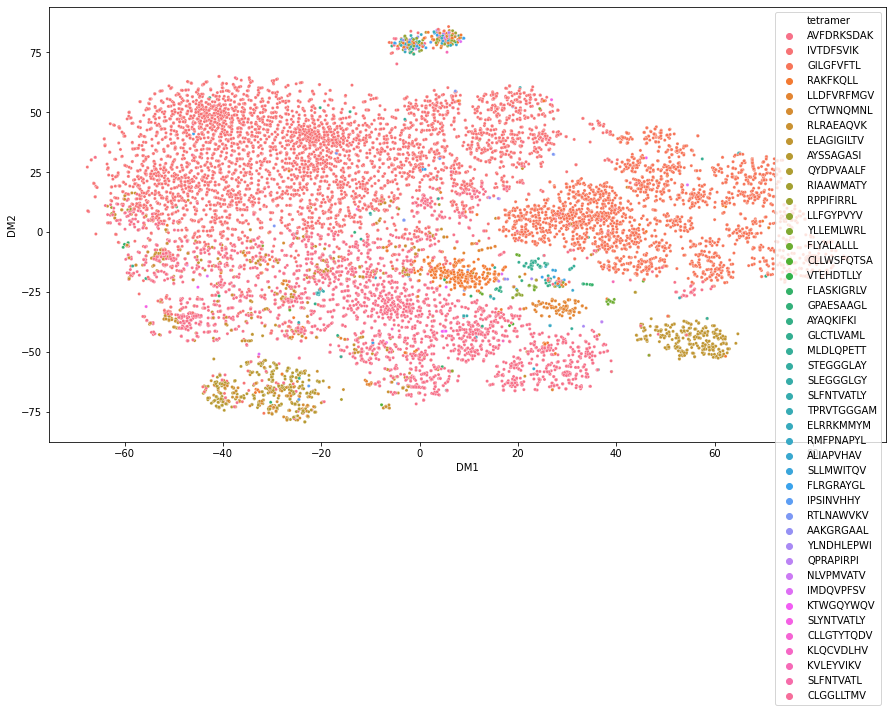

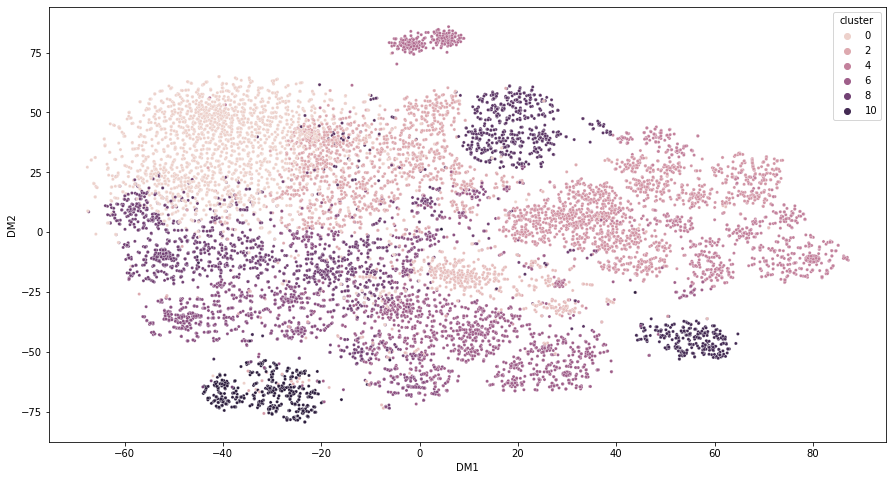

In [42]:
clusters = pd.DataFrame(kmeans.labels_, columns= ['cluster'])
df_kmeans = pd.concat([tsne_df_data, clusters], axis = 1)

plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data, hue='tetramer',s=10)
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=df_kmeans, hue='cluster',s=10)

In [43]:
counts_tetras = barcode_tetramer.groupby('tetramer').count()
counts_tetras.sort_values('barcode')

barcode
tetramer           
VTEHDTLLY         1
CLGGLLTMV         1
CLLGTYTQDV        1
SLYNTVATLY        2
SLFNTVATL         2
KLQCVDLHV         2
CLLWSFQTSA        3
NLVPMVATV         3
SLLMWITQV         4
ALIAPVHAV         4
TPRVTGGGAM        4
SLEGGGLGY         4
RIAAWMATY         4
IPSINVHHY         5
KVLEYVIKV         6
RMFPNAPYL         6
IMDQVPFSV         6
YLNDHLEPWI        6
YLLEMLWRL         8
STEGGGLAY         9
KTWGQYWQV         9
AAKGRGAAL        10
QYDPVAALF        11
QPRAPIRPI        12
RTLNAWVKV        14
MLDLQPETT        15
GPAESAAGL        15
FLASKIGRLV       19
LLFGYPVYV        21
FLYALALLL        23
ELRRKMMYM        23
FLRGRAYGL        26
SLFNTVATLY       28
AYAQKIFKI        29
GLCTLVAML        44
RPPIFIRRL        55
CYTWNQMNL        93
LLDFVRFMGV      157
AYSSAGASI       322
ELAGIGILTV      328
RAKFKQLL        356
RLRAEAQVK       491
GILGFVFTL      2603
AVFDRKSDAK     3320
IVTDFSVIK      4652

In [44]:
counts_tetras_filtered = counts_tetras[counts_tetras['barcode']>30]
counts_tetras_filtered = list(counts_tetras_filtered.index)
counts_tetras_filtered

['AVFDRKSDAK',
 'AYSSAGASI',
 'CYTWNQMNL',
 'ELAGIGILTV',
 'GILGFVFTL',
 'GLCTLVAML',
 'IVTDFSVIK',
 'LLDFVRFMGV',
 'RAKFKQLL',
 'RLRAEAQVK',
 'RPPIFIRRL']

In [45]:
barcode_tetramer_v2 = barcode_tetramer[barcode_tetramer['tetramer'].isin(counts_tetras_filtered)]

data_c_p_v2 = data_c_p[data_c_p.index.isin(barcode_tetramer_v2['barcode'])]
data_c_p_tetramer_v2 = data_c_p_v2.copy()
data_c_p_tetramer_v2 = data_c_p_tetramer_v2.merge(barcode_tetramer_v2, on='barcode')


barcode_tetramer_v2

barcode    tetramer
3       AAACCTGAGATTACCC-16  AVFDRKSDAK
23      AAACCTGAGGGAGTAA-40   IVTDFSVIK
73      AAACCTGAGGTGCACA-13  AVFDRKSDAK
78      AAACCTGAGTGGGTTG-17   GILGFVFTL
80      AAACCTGAGTTTAGGA-39   IVTDFSVIK
...                     ...         ...
212247  TTTGTCAGTGACGCCT-18   IVTDFSVIK
212250  TTTGTCAGTGATAAGT-22  AVFDRKSDAK
212281  TTTGTCAGTTACCGAT-20  AVFDRKSDAK
212320  TTTGTCATCGAGGTAG-13   GILGFVFTL
212322  TTTGTCATCTCCTATA-36  AVFDRKSDAK

[12421 rows x 2 columns]

In [46]:
n_tetra = len(barcode_tetramer_v2['tetramer'].drop_duplicates())
labels = barcode_tetramer_v2['tetramer']

n_start = 4
n_end = n_tetra*2

print(82 * "_")
print("init\t\ttime\tinertia\tn_clust\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

for i in range(n_start,n_end+1):
    kmeans = KMeans(init="random", n_clusters=i, n_init=20, random_state=0)
    bench_k_means(kmeans=kmeans, name="random", data=data_c_p_v2, labels=labels)
    
print(82 * "_")

__________________________________________________________________________________
init		time	inertia	n_clust	homo	compl	v-meas	ARI	AMI	silhouette
random   	0.740s	553660	4	20.000	0.270	0.357	0.307	0.243	0.307
random   	0.842s	543081	5	20.000	0.405	0.438	0.421	0.378	0.420
random   	1.018s	533037	6	20.000	0.366	0.386	0.376	0.329	0.375
random   	1.011s	526880	7	20.000	0.357	0.348	0.352	0.308	0.351
random   	1.055s	520855	8	20.000	0.347	0.316	0.331	0.291	0.330
random   	1.016s	512497	9	20.000	0.344	0.300	0.320	0.280	0.319
random   	1.077s	507189	10	20.000	0.333	0.273	0.300	0.257	0.299
random   	1.185s	500405	11	20.000	0.423	0.327	0.369	0.283	0.367
random   	1.236s	495794	12	20.000	0.408	0.302	0.347	0.255	0.346
random   	1.279s	490017	13	20.000	0.381	0.271	0.317	0.246	0.315
random   	1.362s	483591	14	20.000	0.331	0.237	0.276	0.216	0.274
random   	1.231s	476517	15	20.000	0.417	0.284	0.338	0.223	0.336
random   	1.235s	471610	16	20.000	0.490	0.316	0.384	0.264	0.382
random   	1.393s	462502	17	

In [47]:
tsne_df_data

DM1        DM2              barcode    tetramer
0      16.211845  -9.655579  AAACCTGAGATTACCC-16  AVFDRKSDAK
1     -23.872469  43.797531  AAACCTGAGGGAGTAA-40   IVTDFSVIK
2      30.600014 -59.403248  AAACCTGAGGTGCACA-13  AVFDRKSDAK
3      75.373055 -16.363150  AAACCTGAGTGGGTTG-17   GILGFVFTL
4     -42.612099   0.547552  AAACCTGAGTTTAGGA-39   IVTDFSVIK
...          ...        ...                  ...         ...
12752 -62.422657   7.274702  TTTGTCAGTGATAAGT-22  AVFDRKSDAK
12753  10.694508  14.765654  TTTGTCAGTTACCGAT-20  AVFDRKSDAK
12754  17.896761 -19.695801  TTTGTCATCAGGTAAA-40   AAKGRGAAL
12755  58.999672 -18.732058  TTTGTCATCGAGGTAG-13   GILGFVFTL
12756 -46.832256 -38.065563  TTTGTCATCTCCTATA-36  AVFDRKSDAK

[12757 rows x 4 columns]

In [ ]:
X_embedded = tsne(data_c_p_v2,2,0,25)
tsne_df_v2 = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])
#plt.figure(figsize=(15,8))
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
tsne_df_data_v2 = tsne_df_v2.copy()
tsne_df_data_v2['barcode']=data_c_p_v2.index
tsne_df_data_v2=tsne_df_data_v2.merge(barcode_tetramer_v2, how='right', on='barcode')
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data_v2, hue='tetramer',s=10)



In [ ]:
#Clustering
#Kmeans
n_clus = 5
init_param = "random"
n_init_param = 20
random_state_param = 0
labels = barcode_tetramer_v2['tetramer']
labels = data_c_p_tetramer['tetramer']
kmeans = KMeans(init=init_param, n_clusters=n_clus, n_init=n_init_param, random_state=random_state_param).fit(data_c_p_v2)

In [ ]:
clusters = pd.DataFrame(kmeans.labels_, columns= ['cluster'])
df_kmeans = pd.concat([tsne_df_data_v2, clusters], axis = 1)
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data_v2, hue='tetramer',s=10)
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=df_kmeans, hue='cluster',s=10)

### AgglomerativeClustering

In [ ]:
#Clustering
#AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering
n_tetra = len(barcode_tetramer['tetramer'].drop_duplicates())
labels = data_c_p_tetramer['tetramer']
agglomerative = AgglomerativeClustering(n_clusters=n_tetra, linkage="ward").fit(data_c_p)

In [ ]:
clusters = pd.DataFrame(agglomerative.labels_, columns= ['cluster'])
df_agglomerative = pd.concat([tsne_df_data, clusters], axis = 1)
df_agglomerative

In [90]:
def bench_agglomerative(agglomerative, name, data, labels):
    t0 = time()
    estimator = make_pipeline(StandardScaler(), agglomerative).fit(data)
    fit_time = time() - t0
    results = [name, fit_time,agglomerative.n_clusters]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
 #   results += [
 #       metrics.silhouette_score(
 #           data,
 #           estimator[-1].labels_,
 #           metric="euclidean",
 #           sample_size=300,
 #       )
 #   ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"#\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [ ]:

n_tetra = len(barcode_tetramer['tetramer'].drop_duplicates())
labels = barcode_tetramer['tetramer']

n_start = 4
n_end = n_tetra*2

print(82 * "_")
print("init\t\ttime\tn_clust\thomo\tcompl\tv-meas\tARI\tAMI")

linkage = "single"
for i in range(n_start,n_end+1):
    agglomerative = AgglomerativeClustering(n_clusters=i, linkage=linkage)
    bench_agglomerative(agglomerative=agglomerative, name=linkage, data=data_c_p, labels=labels)

linkage = "complete"
for i in range(n_start,n_end+1):
    agglomerative = AgglomerativeClustering(n_clusters=i, linkage=linkage)
    bench_agglomerative(agglomerative=agglomerative, name=linkage, data=data_c_p, labels=labels)
    
linkage = "average"
for i in range(n_start,n_end+1):
    agglomerative = AgglomerativeClustering(n_clusters=i, linkage=linkage)
    bench_agglomerative(agglomerative=agglomerative, name=linkage, data=data_c_p, labels=labels)
    
linkage = "ward"
for i in range(n_start,n_end+1):
    agglomerative = AgglomerativeClustering(n_clusters=i, linkage=linkage)
    bench_agglomerative(agglomerative=agglomerative, name=linkage, data=data_c_p, labels=labels)
print(82 * "_")

__________________________________________________________________________________
init		time	n_clust	homo	compl	v-meas	ARI	AMI
single   	6.956s	4	0.001	0.428	0.001	0.000	0.001
single   	6.946s	5	0.001	0.345	0.001	0.000	0.001
single   	6.942s	6	0.001	0.394	0.002	0.000	0.001
single   	6.944s	7	0.001	0.387	0.002	0.000	0.001
single   	6.950s	8	0.001	0.350	0.002	0.000	0.001
single   	6.962s	9	0.001	0.379	0.003	0.001	0.002
single   	6.946s	10	0.002	0.405	0.003	0.001	0.002
single   	6.948s	11	0.002	0.377	0.003	0.001	0.002
single   	6.959s	12	0.002	0.375	0.004	0.001	0.002
single   	6.951s	13	0.002	0.403	0.004	0.001	0.003
single   	6.957s	14	0.003	0.417	0.005	0.001	0.003
single   	6.957s	15	0.003	0.413	0.005	0.001	0.003
single   	6.972s	16	0.003	0.394	0.005	0.001	0.003
single   	6.974s	17	0.003	0.410	0.006	0.001	0.004
single   	6.967s	18	0.003	0.411	0.006	0.001	0.004
single   	6.966s	19	0.003	0.396	0.007	0.001	0.004
single   	6.960s	20	0.004	0.410	0.007	0.001	0.004
single   	6.961s	21	0.004	0.